In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Basic libraries
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline


#Other miscellaneous libraries
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

In [55]:
raw_reviews = pd.read_excel('G:/Semester 5/Workshop Analisis Media Sosial/data/Midtown Hotel Surabaya Review.xlsx')
## print shape of dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(raw_reviews.shape))
print (raw_reviews.info())

The shape of the  data is (row, column):(508, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   nama     508 non-null    object        
 1   rating   508 non-null    float64       
 2   tanggal  508 non-null    datetime64[ns]
 3   ulasan   474 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 16.0+ KB
None


In [56]:
#Creating a copy
process_reviews=raw_reviews.copy()

#Checking for null values
process_reviews.isnull().sum()

nama        0
rating      0
tanggal     0
ulasan     34
dtype: int64

In [57]:
process_reviews['ulasan']=process_reviews['ulasan'].fillna('Missing')

***Sentiment Column***

In [58]:
#Figuring out the distribution of categories
process_reviews['rating'].value_counts()

8.5     156
9.7     148
10.0     54
9.4      28
8.8      28
9.1      18
6.0      10
6.3      10
8.4       8
6.2       6
8.7       4
6.5       4
6.7       4
5.6       2
5.8       2
6.6       2
5.4       2
6.1       2
6.4       2
8.2       2
6.9       2
7.0       2
7.1       2
8.6       2
9.0       2
9.6       2
8.0       2
5.2       2
Name: rating, dtype: int64

In [59]:
def f(row):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if row['rating'] >= 8.5:
        val = 'Positive'
    elif row['rating'] >= 6.5:
        val = 'Neutral'
    else:
        val = 'Negative'
    return val

In [60]:
#Applying the function in our new column
process_reviews['sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()

nama  rating    tanggal  \
0  Bartoven V. N.    10.0 2022-11-18   
1       Banina F.    10.0 2022-11-12   
2       Ayu B. E.    10.0 2022-09-11   
3          Ida t.    10.0 2022-06-20   
4       Ira I. A.    10.0 2022-03-26   

                                              ulasan sentiment  
0  Dekat dengan Mall Tunjungan, anak anak senang ...  Positive  
1  Setiap ke Surabaya pasti pilihan utamanya di s...  Positive  
2  Hotel terbaik di kelasnya sangat puas atas pel...  Positive  
3  Sudah ke berapa kalinya menginap di sini, kare...  Positive  
4  Happy banget, bisa ngerayain first wedding ann...  Positive

In [61]:
process_reviews['sentiment'].value_counts()

Positive    442
Negative     38
Neutral      28
Name: sentiment, dtype: int64

***Review text-Punctuation Cleaning***

In [62]:
#Removing unnecessary columns
process_reviews=process_reviews.drop(['nama'], axis=1)
#Creating a copy 
clean_reviews=process_reviews.copy()

In [63]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower() 
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    text = ' '.join(text)
    return text


def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [64]:
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

process_reviews['ulasan']=process_reviews['ulasan'].apply(lambda x:review_cleaning(x))
process_reviews['ulasan']=process_reviews['ulasan'].apply(lambda x:casefoldingText(x))
process_reviews.head()

rating    tanggal                                             ulasan  \
0    10.0 2022-11-18  dekat dengan mall tunjungan anak anak senang s...   
1    10.0 2022-11-12  setiap ke surabaya pasti pilihan utamanya di s...   
2    10.0 2022-09-11  hotel terbaik di kelasnya sangat puas atas pel...   
3    10.0 2022-06-20  sudah ke berapa kalinya menginap di sini karen...   
4    10.0 2022-03-26  happy banget bisa ngerayain first wedding anni...   

  sentiment  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4  Positive

In [65]:
#stemming
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['ulasan']].reset_index(drop=True)
review_features.head()

#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['ulasan'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)  
    


In [66]:
process_reviews=process_reviews.drop(['ulasan'], axis=1)
process_reviews = pd.concat([process_reviews, review_features], axis=1)
process_reviews

rating    tanggal sentiment  \
0      10.0 2022-11-18  Positive   
1      10.0 2022-11-12  Positive   
2      10.0 2022-09-11  Positive   
3      10.0 2022-06-20  Positive   
4      10.0 2022-03-26  Positive   
..      ...        ...       ...   
503     6.7 2023-08-08   Neutral   
504     8.8 2023-01-23  Positive   
505     8.8 2022-09-07  Positive   
506     8.5 2022-07-19  Positive   
507     6.7 2023-08-08   Neutral   

                                                ulasan  
0    dekat dengan mall tunjungan anak anak senang s...  
1    setiap ke surabaya pasti pilihan utamanya di s...  
2    hotel terbaik di kelasnya sangat puas atas pel...  
3    sudah ke berapa kalinya menginap di sini karen...  
4    happy banget bisa ngerayain first wedding anni...  
..                                                 ...  
503  i am connecting wifi using my laptop it is mor...  
504  location is close to tunjungan plaza within wa...  
505  been staying here lots of time still the same ...  
506  great time as always allowed to check in late ...  
507  i am connecting wifi using my laptop it is mor...  

[508 rows x 4 columns]

In [67]:
stop_words = set(stopwords.words('indonesian'))
process_reviews['ulasan'] = process_reviews['ulasan'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()


rating    tanggal sentiment  \
0    10.0 2022-11-18  Positive   
1    10.0 2022-11-12  Positive   
2    10.0 2022-09-11  Positive   
3    10.0 2022-06-20  Positive   
4    10.0 2022-03-26  Positive   

                                              ulasan  
0  mall tunjungan anak anak senang jalan kaki hot...  
1  surabaya pilihan utamanya tempatnya aman nyama...  
2  hotel terbaik kelasnya puas pelayanan hotel ke...  
3  kalinya menginap pelayanan dibantu parkir memu...  
4  happy banget ngerayain first wedding anniversa...

In [68]:
process_reviews['polarity'] = process_reviews['ulasan'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['ulasan'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['ulasan'].apply(lambda x: len(str(x).split()))

In [69]:
process_reviews.head()

rating    tanggal sentiment  \
0    10.0 2022-11-18  Positive   
1    10.0 2022-11-12  Positive   
2    10.0 2022-09-11  Positive   
3    10.0 2022-06-20  Positive   
4    10.0 2022-03-26  Positive   

                                              ulasan  polarity  review_len  \
0  mall tunjungan anak anak senang jalan kaki hot...  0.000000          66   
1  surabaya pilihan utamanya tempatnya aman nyama...  0.000000         105   
2  hotel terbaik kelasnya puas pelayanan hotel ke...  0.000000         111   
3  kalinya menginap pelayanan dibantu parkir memu...  0.000000         295   
4  happy banget ngerayain first wedding anniversa...  0.483333         321   

   word_count  
0          11  
1          14  
2          17  
3          38  
4          44

In [70]:
#Filtering data
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["ulasan"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["ulasan"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["ulasan"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')


c:\users\lenovo\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [71]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["ulasan"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), '#5F9EA0')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["ulasan"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), '#cc5500')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["ulasan"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'maroon')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "Bigram plots of Neutral reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

c:\users\lenovo\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [72]:
## Get the bar chart from positive reviews ##
for sent in review_pos["ulasan"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), '#5F9EA0')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["ulasan"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), '#cc5500')


## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["ulasan"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'maroon')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots')

c:\users\lenovo\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [76]:
## Get the bar chart from positive reviews ##
for sent in review_pos["ulasan"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), '#5F9EA0')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["ulasan"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), '#cc5500')


## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["ulasan"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'maroon')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots')

c:\users\lenovo\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [77]:
text = review_pos["ulasan"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

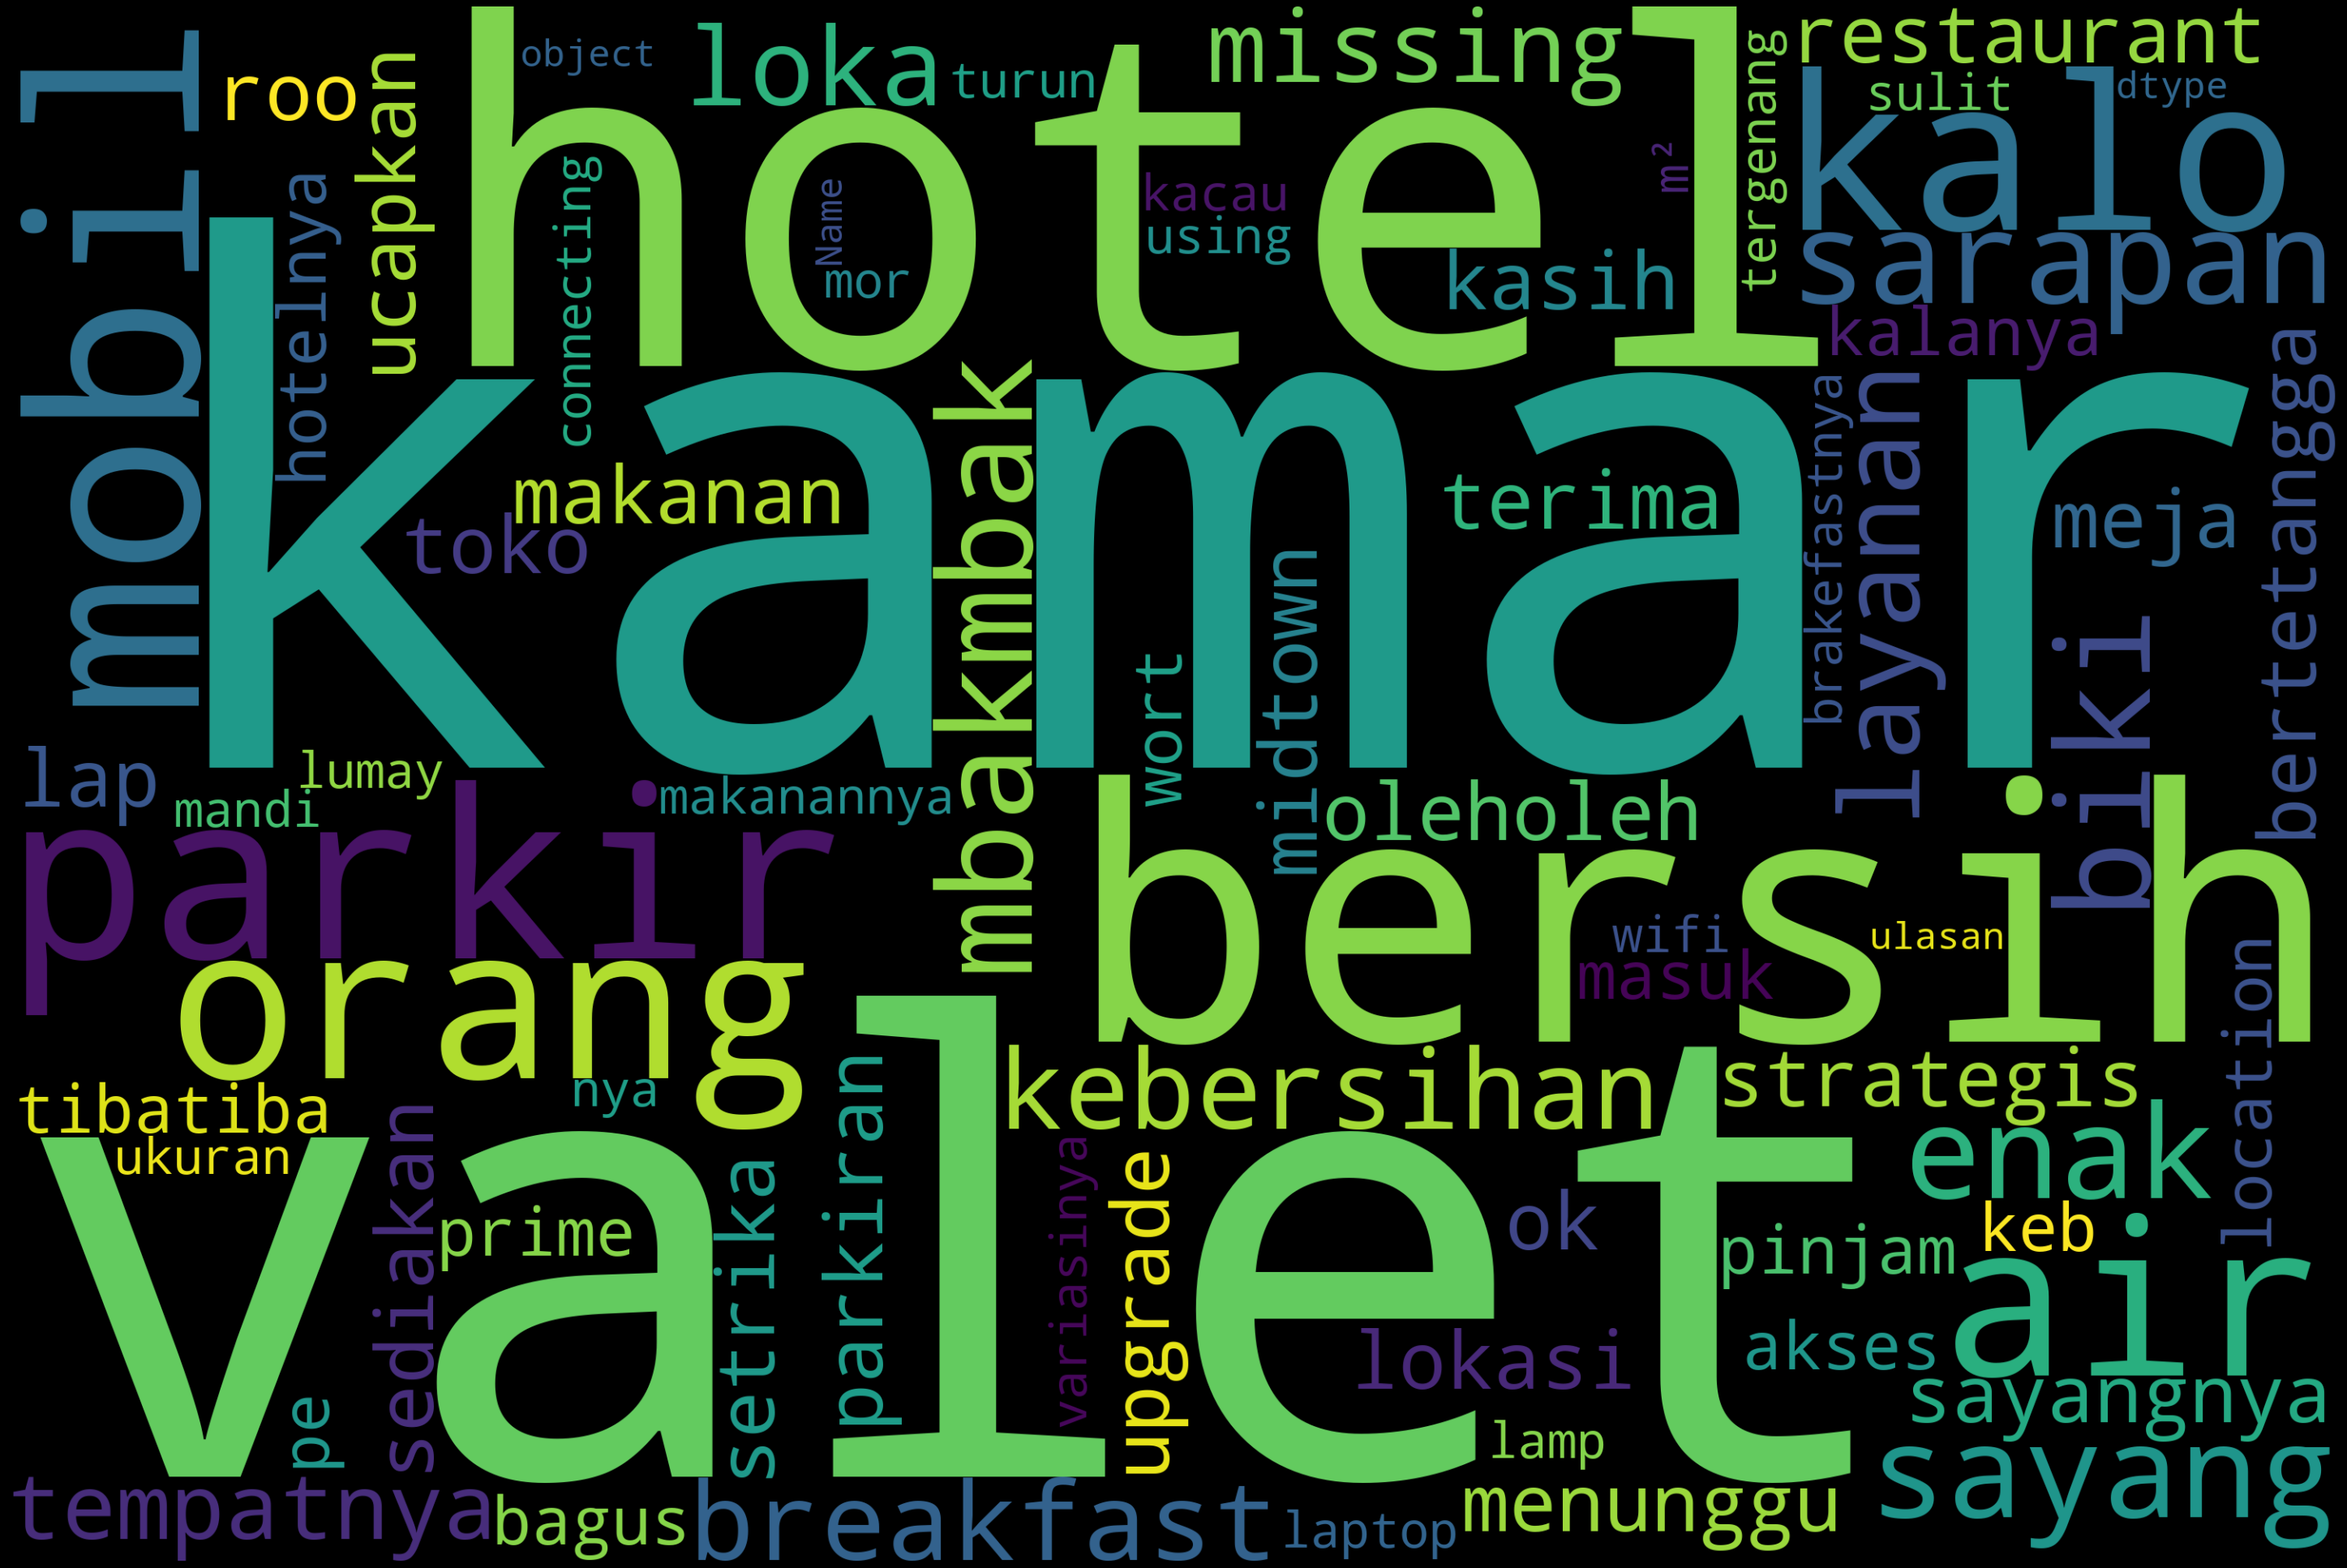

In [78]:
text = review_neu["ulasan"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [79]:
text = review_neg["ulasan"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


***Hotel THe Lifestyle***

In [82]:
raw_reviews = pd.read_excel('G:/Semester 5/Workshop Analisis Media Sosial/data/The Life Style Hotel Surabaya Review.xlsx')
## print shape of dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(raw_reviews.shape))
print (raw_reviews.info())

The shape of the  data is (row, column):(1896, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896 entries, 0 to 1895
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   nama     1896 non-null   object        
 1   rating   1896 non-null   float64       
 2   tanggal  1896 non-null   datetime64[ns]
 3   ulasan   1766 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 59.4+ KB
None


In [83]:
#Creating a copy
process_reviews=raw_reviews.copy()

#Checking for null values
process_reviews.isnull().sum()

nama         0
rating       0
tanggal      0
ulasan     130
dtype: int64

In [84]:
process_reviews['ulasan']=process_reviews['ulasan'].fillna('Missing')

In [85]:
#Figuring out the distribution of categories
process_reviews['rating'].value_counts()

10.0    360
9.7     338
8.5     328
6.0     124
9.4      88
9.1      70
8.8      58
6.3      44
6.1      42
6.5      31
6.4      29
8.7      28
8.4      28
4.8      26
5.4      26
9.3      20
5.5      18
6.7      18
6.6      18
5.7      18
5.8      16
6.2      14
5.2      14
5.1      14
8.2      14
5.9      12
5.6      12
6.9      10
7.2      10
9.6      10
9.0       8
8.6       8
4.9       8
7.0       6
7.5       6
4.5       4
8.9       4
8.0       4
6.8       4
5.3       2
9.2       2
7.1       2
Name: rating, dtype: int64

In [86]:
def f(row):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if row['rating'] >= 8.5:
        val = 'Positive'
    elif row['rating'] >= 6.5:
        val = 'Neutral'
    else:
        val = 'Negative'
    return val

In [87]:
#Applying the function in our new column
process_reviews['sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()

nama  rating    tanggal  \
0     Adrian L. C.    10.0 2023-08-30   
1  Novita Y. Y. O.    10.0 2023-07-25   
2          Faiz D.    10.0 2023-07-10   
3   r reruro g. i.    10.0 2023-04-26   
4          Andi R.    10.0 2023-01-14   

                                              ulasan sentiment  
0  Baik bagus dan menarik sekali untuk menginap d...  Positive  
1  Saya menikmati menginap di sini, lantai 11 pem...  Positive  
2       Nyaman, staff ramah banget, kolam bersih????  Positive  
3  Kamar oke, AC dingin, air panas dan lain-lain ...  Positive  
4  Sangat recommend banget & respect buat all sta...  Positive

In [88]:
process_reviews['sentiment'].value_counts()

Positive    1322
Negative     423
Neutral      151
Name: sentiment, dtype: int64

In [89]:
#Removing unnecessary columns
process_reviews=process_reviews.drop(['nama'], axis=1)
#Creating a copy 
clean_reviews=process_reviews.copy()

In [90]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower() 
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    text = ' '.join(text)
    return text


def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [91]:
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

process_reviews['ulasan']=process_reviews['ulasan'].apply(lambda x:review_cleaning(x))
process_reviews['ulasan']=process_reviews['ulasan'].apply(lambda x:casefoldingText(x))
process_reviews.head()

rating    tanggal                                             ulasan  \
0    10.0 2023-08-30  baik bagus dan menarik sekali untuk menginap d...   
1    10.0 2023-07-25  saya menikmati menginap di sini lantai  pemand...   
2    10.0 2023-07-10             nyaman staff ramah banget kolam bersih   
3    10.0 2023-04-26  kamar oke ac dingin air panas dan lainlain sem...   
4    10.0 2023-01-14  sangat recommend banget  respect buat all staf...   

  sentiment  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4  Positive

In [92]:
#stemming
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['ulasan']].reset_index(drop=True)
review_features.head()

#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['ulasan'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)  
    

In [93]:
process_reviews=process_reviews.drop(['ulasan'], axis=1)
process_reviews = pd.concat([process_reviews, review_features], axis=1)
process_reviews

rating    tanggal sentiment  \
0       10.0 2023-08-30  Positive   
1       10.0 2023-07-25  Positive   
2       10.0 2023-07-10  Positive   
3       10.0 2023-04-26  Positive   
4       10.0 2023-01-14  Positive   
...      ...        ...       ...   
1891     6.0 2023-06-29  Negative   
1892     5.7 2022-02-06  Negative   
1893     6.3 2022-11-18  Negative   
1894     6.0 2023-06-29  Negative   
1895     5.7 2022-02-06  Negative   

                                                 ulasan  
0     baik bagus dan menarik sekali untuk menginap d...  
1     saya menikmati menginap di sini lantai  pemand...  
2                nyaman staff ramah banget kolam bersih  
3     kamar oke ac dingin air panas dan lainlain sem...  
4     sangat recommend banget  respect buat all staf...  
...                                                 ...  
1891  request yang tidak tersedia tidak dikonfirmasi...  
1892  too noisy and their breakfast menubor servickc...  
1893                             security system is bad  
1894  request yang tidak tersedia tidak dikonfirmasi...  
1895  too noisy and their breakfast menubor servickc...  

[1896 rows x 4 columns]

In [94]:
stop_words = set(stopwords.words('indonesian'))
process_reviews['ulasan'] = process_reviews['ulasan'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

rating    tanggal sentiment  \
0    10.0 2023-08-30  Positive   
1    10.0 2023-07-25  Positive   
2    10.0 2023-07-10  Positive   
3    10.0 2023-04-26  Positive   
4    10.0 2023-01-14  Positive   

                                              ulasan  
0                             bagus menarik menginap  
1  menikmati menginap lantai pemandangannya keren...  
2             nyaman staff ramah banget kolam bersih  
3  kamar oke ac dingin air panas lainlain bagus s...  
4  recommend banget respect all staff barang tert...

In [95]:
process_reviews['polarity'] = process_reviews['ulasan'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['ulasan'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['ulasan'].apply(lambda x: len(str(x).split()))

In [96]:
#Filtering data
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["ulasan"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["ulasan"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["ulasan"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')


c:\users\lenovo\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [98]:
## Get the bar chart from positive reviews ##
for sent in review_pos["ulasan"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), '#5F9EA0')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["ulasan"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), '#cc5500')


## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["ulasan"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'maroon')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots')

c:\users\lenovo\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

